Osnabrück University - Machine Learning (Summer Term 2018) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 04: Clustering

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, May 06, 2018**. If you need help (and Google and other resources were not enough), feel free to contact your groups designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

In the following tasks we will be relying on numpy. Using the following import we expect it to be in global scope as `np`. Therefore we can, after executing the following cell, use stuff like `np.array` and `np.sqrt`. Check out the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html) and especially search it using e.g. [Google Site Search](https://www.google.de/search?q=array+site%3Adocs.scipy.org%2Fdoc%2Fnumpy)! You can also try `np.lookfor('keyword search docstrings')` to get help.

In [1]:
import numpy as np
np.lookfor('get array diagonal')

Search results for 'get array diagonal'
---------------------------------------
numpy.fill_diagonal
    Fill the main diagonal of the given array of any dimensionality.
numpy.mask_indices
    Return the indices to access (n, n) arrays, given a masking function.


## Assignment 0: Math recap (Eigenvectors and Eigenvalues) [2 Bonus Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is an eigenvector of a matrix/a linear mapping? What are eigenvalues?

YOUR ANSWER HERE

**b)** What is the characteristic polynomial of a matrix? How is it related to eigenvalues? What are algebraic and geometric multiplicity of an eigenvalue?

YOUR ANSWER HERE

**c)** What is the spectrum of a matrix? What does the spectral theorem state?

YOUR ANSWER HERE

**d)** [bonus task]: Numpy/Scipy provide functions to compute eigenvalues. Lookup these functions and apply them to an example.

In [2]:
# YOUR CODE HERE

## Assignment 1: Distance Measures [4 Points]

This exercise is focused on implementing some distance functions that later on help with the clustering. They should all use the euclidean distance as a measurement. The first function is closely related to the MATLAB pdist2 function. This is the summary from the [documentation](http://de.mathworks.com/help/stats/pdist2.html):

*D = pdist2(X,Y) returns a matrix D containing the Euclidean distances between each pair of observations in the mx-by-n data matrix X and my-by-n data matrix Y. Rows of X and Y correspond to observations, columns correspond to variables. D is an mx-by-my matrix, with the (i,j) entry equal to distance between observation i in X and observation j in Y. The (i,j) entry will be NaN if observation i in X or observation j in Y contain NaNs.*

In [3]:
from math import sqrt, fsum, isnan

def euclid(x, y):
    """
    Computes euclidean distance between two vectors of dimension n
    
    Args:
        x (ndarry): Observation A
        y (ndarry): Observation B
        
    Returns:
        float: distance between x and y meaused by the euclidean norm
    """       
    return sqrt(fsum([(a-b)**2 if not isnan(a) and not isnan(b) else float('NaN') for a,b in zip(x,y)]))

def pdist2(x, y):
    """
    Pairwise distance between all points of two datasets.
    
    Args:
        x (ndarray): Containing j data points of dimension n. Shape (j, n).
        y (ndarray): Containing k data points of dimension n. Shape (k, n).
        
    Returns:
        ndarray: Pairwise distances between all data points. Shape (j, k).
    """
    return np.array([[euclid(a, b) for b in y] for a in x])

x = np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]])
y = np.array([[13,14,15], [16,17,18], [19,20,21]])
n = np.array([[1,2,3], [float('NaN'),1,0]])

assert pdist2(x, y).shape == (4, 3), "Shape is wrong: {}".format(pdist2(x, y).shape)
assert np.round(pdist2(x, y)[3,0], 3) == 5.196, "[10,11,12] and [13,14,15] is wrong: {}".format(pdist2(x, y)[3,0])
assert np.round(np.mean(pdist2(x, y)), 3) == 18.187, "Mean distance is wrong: {}".format(np.mean(pdist2(x, y)))
assert np.isnan(pdist2(x, n)[0,1]), "Should be NaN: {}".format(pdist2(x, n)[0,1])

Now implement the $d_{mean}$ and $d_{centroid}$ distance from the lecture. Each function expects two clusters each represented by a 2-dimensional numpy array, where the number of columns $n$ reflects the dimensionality of the data space and has to agree for both clusters, while the number of rows $mx$ and $my$ can vary from cluster to cluster. The return value is the respective distance.

In [4]:
def d_mean(cluster1, cluster2):
    """
    Mean distance between points of two clusters.
   
    Args:
        cluster1 (ndarray): Points belonging to cluster 1 of shape (num_points, num_dimensions).
        clusterd (ndarray): Points belonging to cluster 1 of shape (num_points, num_dimensions).
    
    Returns:
        float: The mean distance between the points in the two clusters.
    """
    if cluster1.shape[1] != cluster2.shape[1]:
        raise Exception("d_mean: clusters must have equal dimension")
        
    return np.sum(pdist2(cluster1, cluster2)) / (cluster1.shape[0]*cluster2.shape[0])

x = np.array([[1,2,3], [4,5,6], [7,8,9]])
y = np.array([[13,14,15], [16,17,18], [19,20,21], [5,45,1], [1,12,7]])

assert np.round(d_mean(x, y), 3) == 22.297, "Result is not correct: {}".format(d_mean(x, y))
assert d_mean(x, y) == d_mean(y, x), "X,Y is not equal to Y,X: {} != {}".format(d_mean(x, y), d_mean(y, x))

In [5]:
def d_centroid(cluster1, cluster2):
    """
    Calculate the distance between the centroids of two clusters.
    
    Args:
        cluster1 (ndarray): Points belonging to cluster 1 of shape (num_points, num_dimensions).
        clusterd (ndarray): Points belonging to cluster 1 of shape (num_points, num_dimensions).
    
    Returns:
        float: The distance between the centroids of two clusters.
    """
    len1 = cluster1.shape[0]
    len2 = cluster2.shape[0]
    return euclid([a / len1 for a in np.array(np.sum(cluster1, axis=0))], \
                  [b / len2 for b in np.array(np.sum(cluster2, axis=0))])

x = np.array([[1,2,3], [4,5,6], [7,8,9]])
y = np.array([[13,14,15], [16,17,18], [19,20,21]])
z = np.array([[-2,0], [-1,100]])
w = np.array([[2,0], [1,100], [1,-100], [1,-20]])

assert np.round(d_centroid(x, y), 3) == 20.785, "Result is not correct: {}".format(d_centroid(x, y))
assert np.round(d_centroid(z, w), 3) == 55.069, "Result is not correct: {}".format(d_centroid(z, w))
assert d_centroid(x, y) == d_centroid(y, x), "X,Y is not equal to Y,X: {} != {}".format(d_centroid(x, y), d_centroid(y, x)) 

## Assignment 2: Hierarchical Clustering [2 Points]

In the following you find implementations for single- and complete-linkage clustering. *This implementation relies on the distance functions you wrote in Assignment 1 (if you get stuck on the first exercise write an email to the tutors and we will help you along).* Take a look at the code (this might also help if you get stuck on assignment 3) and answer the question posted below. You may of course change parameters and try it out on different datasets (`points.txt` & `clusterData.txt` are provided).

Note that for performance reasons the code differs from the lecture's pseudocode (ML-05 Slide 8), but in general it does the same.

In [6]:
def linkage(data, k=5, complete=False):
    """
    Runs single or complete linkage clustering.
    
    Args:
        data (ndarray): Data points to be clustered in an array with shape (num_points, 2).
        k (int): Number of clusters.
        complete (bool): Whether to run complete linkage clustering.
        
    Returns:
        ndarray: The cluster labels for each data point. Shape is (num_points).
    """
    # Initially all points are their own cluster.
    labels = np.arange(len(data))

    # Calculate distance between all points.
    # Also removing half of the matrix because 
    # its symmetrical along the diagonal.
    dst = np.tril(pdist2(data, data))

    while len(set(labels)) > k:
        # Get the lowest distance of two points which
        # do not have the same label.
        r, c = np.where(dst == np.min(dst[dst > 0]))
        
        # Ignore the case when there are multiple with
        # equally smallest distance.
        r = r[0]
        c = c[0]

        # The two points are now in the same cluster,
        # so they have a distance of 0 now.
        dst[r, c] = 0

        # Make the two clusters have the same label.
        labels[labels == labels[r]] = labels[c]

        # Check if we want to do complete linkage clustering.
        if complete:
            # Update the distances of the points which are not in the same cluster.
            for i in np.nonzero(dst[r, :] > 0)[0]:
                dst[r, i] = np.max(pdist2(data[i, None], data[labels == labels[r], :]))

            # The distances to c are now the same as to r, so we can just
            # set them to zero - would be duplicates otherwise.
            dst[:, c] = 0

    return labels

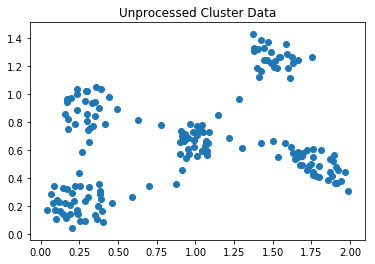

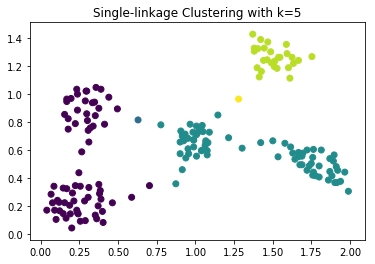

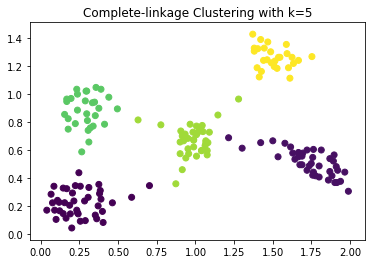

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Read the data.
data = np.loadtxt('points.txt')
# data = np.loadtxt('clusterData.txt')

# Show unprocessed data set.
fig_cluster = plt.figure()
plt.scatter(data[:, 0], data[:, 1])
plt.title('Unprocessed Cluster Data')
fig_cluster.canvas.draw()

# Apply Single Linkage Clustering
labels = linkage(data, k=5, complete=False)
fig_single = plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.title('Single-linkage Clustering with k=5')
fig_single.canvas.draw()

# Apply Complete Linkage Clustering
labels = linkage(data, k=5, complete=True)
fig_complete = plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.title('Complete-linkage Clustering with k=5')
fig_complete.canvas.draw()

What is the difference between single- and complete-linkage clustering and which is the better solution given the dataset?

YOUR ANSWER HERE

## Assignment 3: k-means Clustering [8 Points]

Implement k-means clustering. Plot the results for $k = 7$ and $k = 3$ in colorful scatter plots.

How could one handle situations when one or more clusters end up containing 0 elements?

In [74]:
def getCK(data, labels, idx):
    """
    Filters data points according to the cluster they belong to,
    identified by the index 'idx'.
    
    Args:
        data (ndarray): data
        labels (array): cluster labels for the data
        idx (integer): cluster index
        
    Returns:
        ndarray of data belonging to cluster 'idx'
    """
    filtered = []
    for i, entry in enumerate(data):
        if labels[i] == idx-1:
            filtered.append(entry)
            
    return filtered

def kmeans(data, k=3):
    """
    Applies kmeans clustering to the data using k initial clusters.
    data is expected to be a numpy array of size n*2, 
    n being the amount of observations in the data. This function returns
    the centroids and the labels for the clusters data (1,1,3,5,5,5,...)
    
    Args:
        data (ndarray): data of size 2n
           k (integer): number of clusters to assign
           
    Returns:
        data labels and centroids (clusters)
    """
    # Initialize random reference vectors by randomly drawing k 
    # observations from the dataset
    n = data.shape[0]
    centroids = data[np.random.randint(n, size=k), :]
    labels = np.zeros(n, dtype=np.int32)
    changes = np.full(k, np.iinfo(np.int32).max, dtype=np.int32)
    epsilon = 0.1
    
    itercount = 0
    
    while True:
        # Generate distance matrix for all observations with all centroids
        distances = pdist2(data, centroids)
    
        # Assign data to best matching reference vector
        labels = [min_c+1 for min_c in np.argmin(distances, axis=1)]

        # Stop if centers have moved maximally epsilon
        if itercount == 1000 or all([x <= epsilon for x in changes]):
            break
            
        # Update reference vectors by shifting to mean of their cluster
        tmp_centroids = np.zeros((k,2))
        for idx, val in enumerate(centroids):
            ck_vals = getCK(data, labels, idx)
            count = len(ck_vals)
            if count > 0:
                res = np.array(np.sum(ck_vals, axis=0))
                tmp_centroids[idx,:] = [tmp / count for tmp in res]
            else:
                tmp_centroids[idx,:] = centroids[idx,:]
            
        changes = [euclid(c, c_minus_1) for c, c_minus_1 in zip(centroids, tmp_centroids)]
        centroids = tmp_centroids
        itercount += 1
    
    return labels, centroids

Start plotting k-means ...


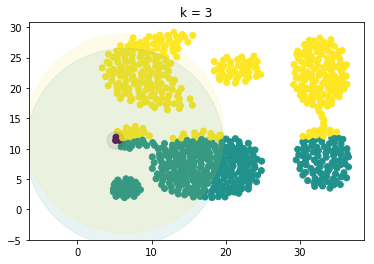

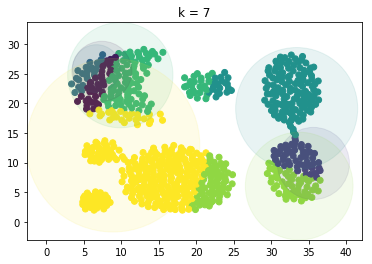

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

def count_labels(data, label):
    count = 0
    for val in data:
        if val == label:
            count += 1
    return count

print("Start plotting k-means ...")

data = np.loadtxt('clusterData.txt')

for k in [3, 7]:
    labels, centroids = kmeans(data, k)
    
    kmeans_fig = plt.figure('k-means with k={}'.format(k))
    plt.scatter(data[:,0], data[:,1], c=labels)
    plt.scatter(centroids[:,0], centroids[:,1], 
                c=list(set(labels)), alpha=.1, marker='o',
                s=np.array([count_labels(labels, label) for label in set(labels)])*100)
    plt.title('k = '+str(k))
    kmeans_fig.canvas.draw()

## Assignment 4: Covariance and autocorrelation matrix [6 Points]

**a)** What is the coveriance matrix? What do the different entries of the matrix mean? 

YOUR ANSWER HERE

**b)** What can the covariance matrix be used for? Name at least two applications.

YOUR ANSWER HERE

**c)** Execute the next cell. You can see three data sets. Which of the three covariance matrices below belongs to which plot?

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize = (20,5))
factors = [0.5,1,0]
names = ["a", "b", "c"]
datasets = []
for i, factor in enumerate(factors):
    x = np.array(np.arange(100).tolist() + np.arange(100).tolist())
    if factor!=0:
        y = x * factor + (np.random.rand(len(x))-0.5)*30
    else:
        y = np.array([50 for _ in range(len(x))]) + (np.random.rand(len(x))-0.5)*30
    plt.subplot(1,len(factors),i+1)
    plt.scatter(x,y)
    plt.title("Dataset "+names[i], fontsize = 30)
    plt.xlabel("x", fontsize = 20)
    plt.ylabel("y", fontsize = 20)
    plt.ylim(0, 100)
    plt.xlim(0, 100)
    datasets.append(np.stack([x, y], axis = 1))
plt.show()

**Covariance matrix I:**

|  | x | y |
| ---|---|---|
|   **x** |  837 | 877  |
|   **y**| 877  |  989 |

**Covariance matrix II:**

|  | x | y |
| ---|---|---|
|   **x** |  837 | 1  |
|   **y**| 1  |  66 |


**Covariance matrix III:**

|  | x | y |
| ---|---|---|
|   **x** |  837 | 453  |
|   **y**| 453  |  318 |


YOUR ANSWER HERE

**d)** Implement the formula for the autocorrelation matrix given in the lecture

$$ A = \frac{1}{N} \sum_{x \in D} (x - \mu) (x- \mu)^T$$

Then execute the cell below which shows the autocorrelation matrices for the datasets of task c.

In [ ]:
def covariance(data):
    """
    Input is an array of the form number_data * dimensions
    An example is shown when this cell is executed
    """
    
    # YOUR CODE HERE
    
## DELETE COMMENTS TO SHOW THE DATA USED FOR ASSERTION 
# example_x = [2,2,2]
# example_y = [1,2,3]
# example_data = np.stack([[1,2,3], [2,2,2]], axis = 1)
# plt.scatter(example_x, example_y)
# plt.show()

assert covariance(np.stack([[1,2,3], [2,2,2]], axis = 1))[0,1]==0, "Wrong output: correlation should be zero for this data, is ".format(autocorrelation(np.stack([[1,2,3], [2,2,2]], axis = 1))[0,1])
assert covariance(np.stack([[1,2,3], [4,5,6]], axis = 1))[0,0].round(2)==0.67, "Wrong output: should be 0.67, is ".format(autocorrelation(np.stack([[1,2,3], [4,5,6]], axis = 1))[0,1])
assert covariance(np.stack([[1,2,3], [4,5,6]], axis = 1))[0,1].round(2)==0.67, "Wrong output: should be 0.67, is ".format(autocorrelation(np.stack([[1,2,3], [4,5,6]], axis = 1))[0,1])

In [ ]:
# the data of task c is saved in a list called datasets
for i, d in enumerate(datasets):
    print("Covariance matrix for data set", names[i], "\n", covariance(d), "\n")

**e)** What is the difference between autocorrelation matrix and covariance matrix? How is it computed? When should it be used?

YOUR ANSWER HERE